# Setup

In [1]:
import numpy as np
from classy import Class
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# some plotting settings to make figures prettier :)
mpl.rcParams['text.usetex'] = False
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.minor.size'] = 5
#plt.rcParams["font.family"] = "Times New Roman"

default parameters is set as a function, such that config can be called to return to default after modifications

In [2]:
def config_default():
    config = {
        # cosmo parameters:
        'h': 0.67810, 'A_s': 2.100549e-09, 'omega_b': 0.0238280, 
        'omega_cdm': 0.1201075, 'N_ur': 3.044, 'z_pk': 0, 
        'output' : 'tCl,pCl,lCl,mPk',
        # precision parameters:
        'lensing': 'yes', 'P_k_max_1/Mpc': 1., 'l_max_scalars': 2500,
    }
    return config

In [3]:
config = config_default()
cosmo = Class() 
cosmo.set(config)
cosmo.compute()

In [4]:
# dir(cosmo)

# Background Evolution

In [5]:
be = cosmo.get_background()

In [6]:
# pulling data out of be
z = be['z']
t = be['proper time [Gyr]']
rho_b, rho_cdm, rho_lambda, rho_g, rho_ur = be['(.)rho_b'], be['(.)rho_cdm'], be['(.)rho_lambda'], be['(.)rho_g'], be['(.)rho_ur']
rho_m = rho_b + rho_cdm
rho_r = rho_g + rho_ur
rho_tot = rho_m + rho_r + rho_lambda

### Relation between z and t

In [7]:
#z.max()

In [8]:
def convert_to_t(z_value):
    if z_value < 0 or z_value > z.max():
        print(f"{z_value} is not a possible z_value")
        return
    f = interp1d(z, t, kind = 'cubic')
    return float(f(float(z_value))) # f gives value in array, convert to float
# t unit: Gy (after Big Bang)
def convert_to_z(t_value):
    if t_value < 0 or t_value > t.max():
        print(f"{t_value} is not a possible t_value")
        return
    f = interp1d(t, z, kind = 'cubic')
    return float(f(float(t_value)))

Example:

In [9]:
Gy = 20
redshift = 1000
print(f"z = {redshift} means {convert_to_t(redshift)} Gy after the Big Bang")
print(f"{Gy} Gy after Big Bang gives redshift of {convert_to_z(Gy)}")

z = 1000 means 0.00042802803555809445 Gy after the Big Bang
20 is not a possible t_value
20 Gy after Big Bang gives redshift of None


In [10]:
def plot_t_z():
    plt.semilogy(t, z)
    plt.title("Redshift vs. Time")
    plt.xlabel("Gy after big bang")
    plt.ylabel("z")
    plt.show()

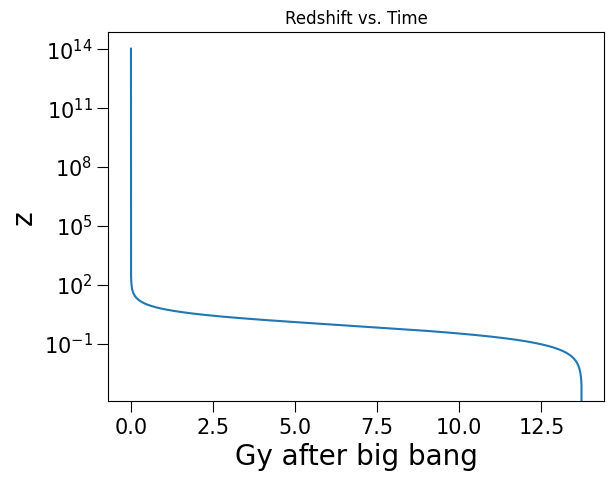

In [11]:
plot_t_z()

### Energy densities vs. redshift/time

In [12]:
para_name = {'b': r'$\Omega_{baryon}$', 'cdm': r'$\Omega_{cdm}$', 'Lambda': r'$\Omega_{\Lambda}$', 'g': r'$\Omega_{g}$',
             'ur': r'$\Omega_{ur}$', 'm': r'$\Omega_{matter}$', 'r': r'$\Omega_{rad.}$', 'tot': r'$\Omega_{total}$'} 

In [13]:
def z_evolution(parameter, parameter_name: str): # parameters: rho_r, rho_m, rho_lambda, rho_cdm, etc
    plt.loglog(z, parameter, label = parameter_name)
    plt.xlim(1e7, 1e-1)
    #plt.ylim(1e-10, 1e25)
    plt.xlabel('$z$')
    plt.ylabel('$\Omega$')
    
def t_evolution(parameter, parameter_name: str):
    plt.loglog(t, parameter, label = parameter_name)
    plt.xlabel('Gys after the big bang')
    plt.ylabel('$\Omega$')

In [14]:
def plot_omega_z():
    f = plt.figure()
    z_evolution(rho_r, r'$\Omega_{r}$')
    z_evolution(rho_m, r'$\Omega_{m}$')
    z_evolution(rho_lambda, r'$\Omega_{\Lambda}$')
    plt.legend()
    plt.show()

Examples: 

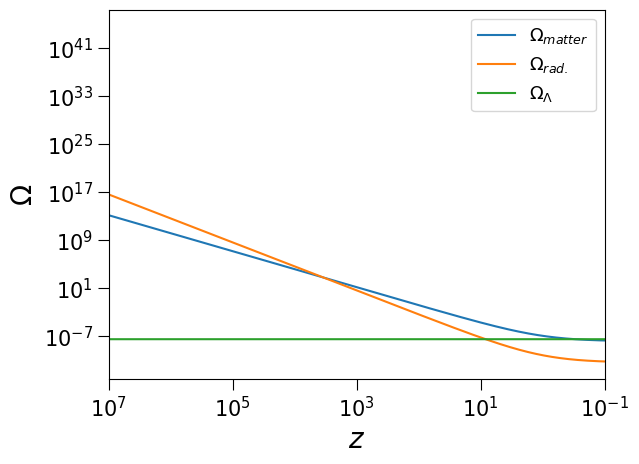

In [15]:
z_evolution(rho_m, para_name['m'])
z_evolution(rho_r, para_name['r'])
z_evolution(rho_lambda, para_name['Lambda'])
plt.legend()
plt.show()

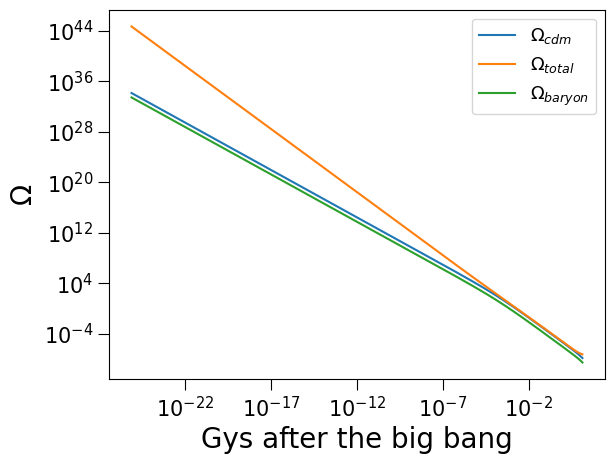

In [16]:
t_evolution(rho_cdm, para_name['cdm'])
t_evolution(rho_tot, para_name['tot'])
t_evolution(rho_b, para_name['b'])
plt.legend()
plt.show()

In [17]:
def plot_omega_prop_z():
    f = plt.figure()

    plt.semilogx(z, rho_r/rho_tot, label = para_name['r'])
    plt.semilogx(z, rho_m/rho_tot, label = para_name['m'])
    plt.semilogx(z, rho_lambda/rho_tot, label = para_name['Lambda'])

    plt.xlabel('$z$')
    plt.ylabel('$\Omega$')
    plt.legend()
    plt.xlim(1e7, 1e-1)

    plt.title('proportions of energy densities')
    
    plt.show()

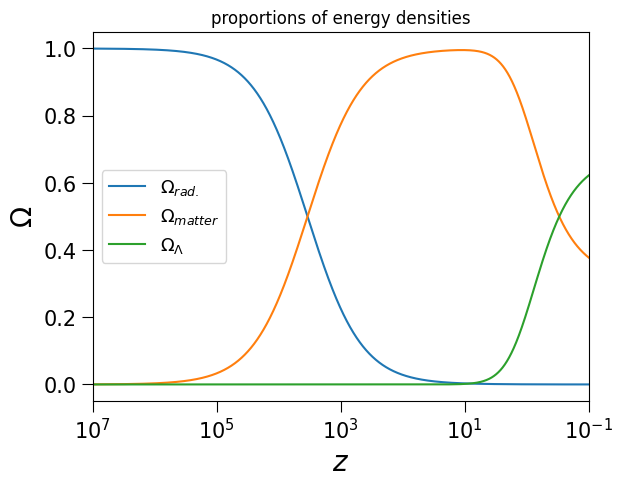

In [18]:
plot_omega_prop_z()

### Dominance eras

In [19]:
def equality_z(parameter_1, parameter_2):
    f1 = interp1d(z, parameter_1, kind = 'cubic')
    f2 = interp1d(z, parameter_2, kind = 'cubic')
    def find_intersection(x):
        return f1(x) - f2(x)
    initial_guess = z[int(len(z)/2)]
    intersection_x = fsolve(find_intersection, initial_guess)
    return intersection_x

Example:

In [20]:
z_1 = equality_z(rho_m, rho_r)
z_2 = equality_z(rho_lambda, rho_m)
year = convert_to_t(equality_z(rho_lambda, rho_m))
print('Lambda and m reaches equality' + f' {year} Gy after the Big Bang')
print(f'The matter-dominated era is between z = {z_1} and {z_2}')

Lambda and m reaches equality 10.217513477867659 Gy after the Big Bang
The matter-dominated era is between z = [3440.30389397] and [0.29947357]


### Time vs. expansion rate

In [21]:
def expansion_t():
    a = 1/(1+z)
    plt.plot(t, a)
    plt.xlabel('Gy after Big Bang')
    plt.ylabel('expansion rate')
    plt.show()

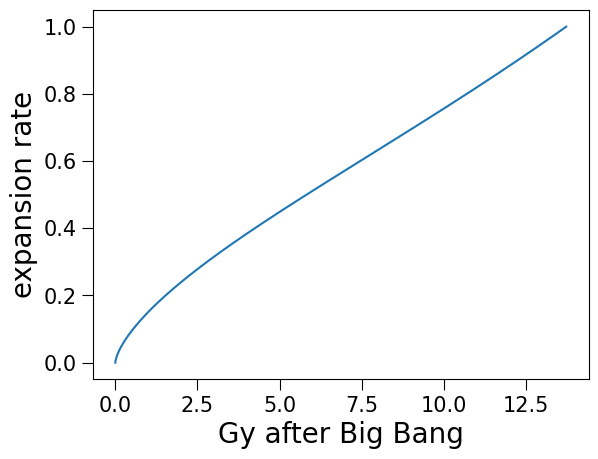

In [22]:
expansion_t()

Reminder(during creating repo): git ignore for python notebooks(auxialliary files)

# Model Universes (to be contd)